In [1]:
from collections import defaultdict
import sys
sys.path.append("../../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [2]:
aqt_results = pd.read_csv("./QMarina-AQT-4Q.csv", index_col=0)
aqt_results = aqt_results.set_index(["Time", "Protocol", "Randomizations", "Identities"])

aqt_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0001",
    "Cavity + Environment": "0010",
}

normed_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2 and 3": "avg_0100_0001",
    "Cavity + Environment": "0010",
}

In [3]:
def norm_and_average(df):
    norm_df = df.copy()
    norm_df[['1000', '0100', '0010', '0001']] = norm_df[['1000', '0100', '0010', '0001']].divide(norm_df[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
    norm_df['avg_0100_0001'] = norm_df[['0100', '0001']].mean(axis=1)
    return norm_df

In [4]:
N = 3
g = 4
kappa = 2
times = np.linspace(0, 3, 51)

In [5]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)
qutip_results["Emitter 2 and 3"] = qutip_results["Emitter 2"]

In [6]:
rms = {
    "raw": {},
    "raw normed": {},
    "RC 40": {},
    "RC 40 normed": {},
    "RC 80": {},
    "RC 80 normed": {},
    "NOX 1": {},
    "NOX 1 normed": {},
    "NOX 2": {},
    "NOX 2 normed": {},
    "NOX 3": {},
    "NOX 3 normed": {},
    "NOX 4": {},
    "NOX 4 normed": {},
    "NOX 6": {},
    "NOX 6 normed": {},
}

mae = {
    "raw": {},
    "raw normed": {},
    "RC 40": {},
    "RC 40 normed": {},
    "RC 80": {},
    "RC 80 normed": {},
    "NOX 1": {},
    "NOX 1 normed": {},
    "NOX 2": {},
    "NOX 2 normed": {},
    "NOX 3": {},
    "NOX 3 normed": {},
    "NOX 4": {},
    "NOX 4 normed": {},
    "NOX 6": {},
    "NOX 6 normed": {},
}

mre = {
    "raw": {},
    "raw normed": {},
    "RC 40": {},
    "RC 40 normed": {},
    "RC 80": {},
    "RC 80 normed": {},
    "NOX 1": {},
    "NOX 1 normed": {},
    "NOX 2": {},
    "NOX 2 normed": {},
    "NOX 3": {},
    "NOX 3 normed": {},
    "NOX 4": {},
    "NOX 4 normed": {},
    "NOX 6": {},
    "NOX 6 normed": {},
}

# Raw

## RMS and MAE

Emitter 1 RMS 1.4502429304615068
Emitter 2 RMS 0.3189974730165633
Emitter 3 RMS 0.43880275598337465
Cavity + Environment RMS 0.6095877825439562


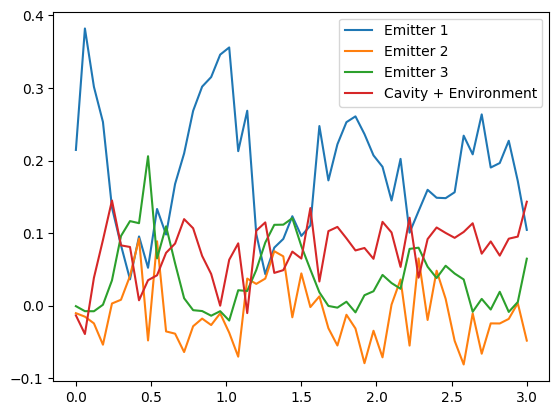

In [7]:
raw_data = aqt_results.xs("RAW", level="Protocol")

for col, bitstr in aqt_bitstrs.items():
    diff = qutip_results[col] - np.array(raw_data[bitstr])
    print(col, "RMS", np.sqrt(np.sum(diff**2)))
    rms["raw"][col] = np.sqrt(np.sum(diff**2))
    mae["raw"][col] = np.mean(np.abs(diff))
    mre["raw"][col] = np.mean(np.abs(diff).iloc[1:] / qutip_results[col].iloc[1:])
    plt.plot(times, diff, label=col)

em23_mean = 0.5 * (np.array(raw_data[aqt_bitstrs["Emitter 2"]]) + np.array(raw_data[aqt_bitstrs["Emitter 3"]]))
diff = qutip_results[col] - em23_mean
raw_23_mean_mae = np.mean(np.abs(diff))

plt.legend()

## Fourier

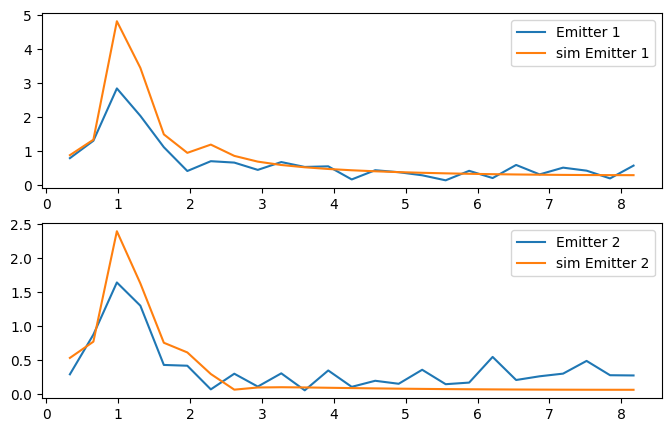

In [8]:
raw_data = aqt_results.xs("RAW", level="Protocol")
n = len(raw_data)

fig, axes = plt.subplots(2, 1, figsize=(8, 5))

for (col, bitstr), ax in zip(aqt_bitstrs.items(), axes.flatten()):
    fft = np.fft.rfft(raw_data[bitstr], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label=col)

    fft = np.fft.rfft(qutip_results[col], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label="sim " + col)

    ax.legend()

# Raw normed

## RMS and MAE

Emitter 1 RMS 0.6080168250710373
Emitter 2 and 3 RMS 0.2663487267828903
Cavity + Environment RMS 0.330786839693802


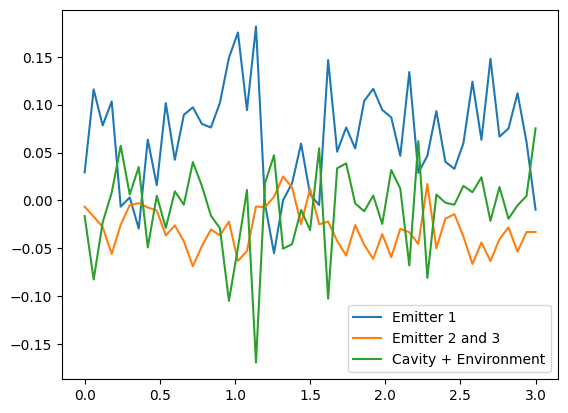

In [9]:
raw_data_norm = norm_and_average(raw_data)

for col, bitstr in normed_bitstrs.items():
    diff = qutip_results[col] - np.array(raw_data_norm[bitstr])
    print(col, "RMS", np.sqrt(np.sum(diff**2)))
    rms["raw normed"][col] = np.sqrt(np.sum(diff**2))
    mae["raw normed"][col] = np.mean(np.abs(diff))
    mre["raw normed"][col] = np.mean(np.abs(diff).iloc[1:] / qutip_results[col].iloc[1:])
    plt.plot(times, diff, label=col)

plt.legend()

## Fourier

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_80097/3040193962.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


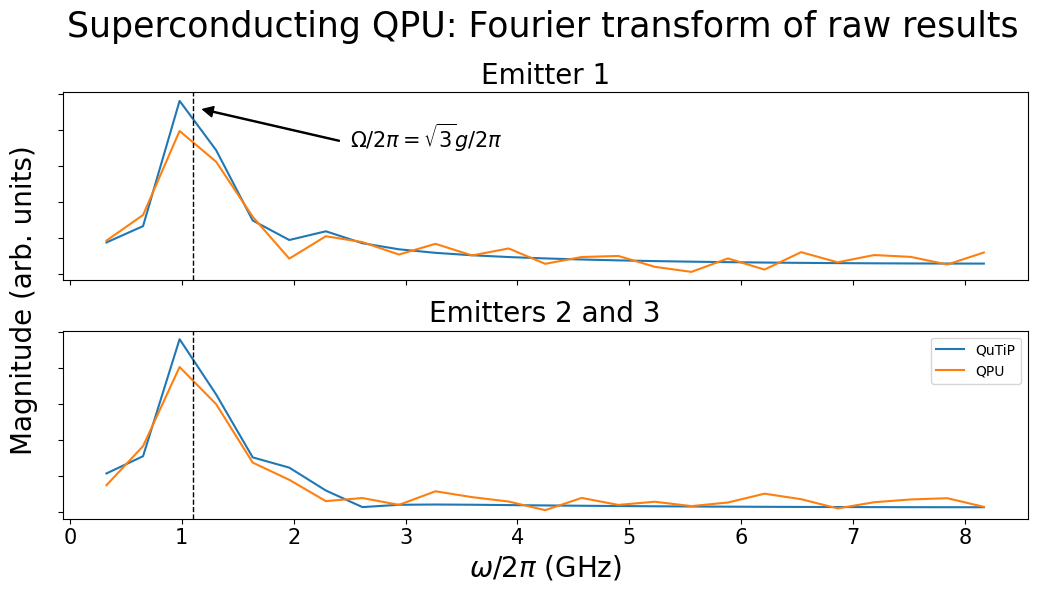

In [10]:
rabi_freq = np.sqrt(3) * g / (2*np.pi)

n = len(raw_data_norm)

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

freqs = np.fft.rfftfreq(n, times[1] - times[0])[1:]

##

em1_fft = np.abs(np.fft.rfft(qutip_results["Emitter 1"], n)[1:])
axes[0].plot(freqs, em1_fft, label="QuTiP")

em1_fft = np.abs(np.fft.rfft(raw_data_norm[normed_bitstrs["Emitter 1"]], n)[1:])
axes[0].plot(freqs, em1_fft, label="QPU")

axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_title("Emitter 1", fontsize=20)
axes[0].axvline(rabi_freq, lw=1, color='black', linestyle='--')

##

em23_fft = np.abs(np.fft.rfft(qutip_results["Emitter 2"], n)[1:])
axes[1].plot(freqs, em23_fft, label="QuTiP")

em23_fft = np.abs(np.fft.rfft(raw_data_norm[normed_bitstrs["Emitter 2 and 3"]], n)[1:])
axes[1].plot(freqs, em23_fft, label="QPU")

axes[1].tick_params(axis='x', labelsize=15)
axes[1].set_yticklabels([])
axes[1].set_title("Emitters 2 and 3", fontsize=20)
axes[1].axvline(rabi_freq, lw=1, color='black', linestyle='--')
axes[1].set_xlabel(r"$\omega / 2\pi$ (GHz)", fontsize=20)


fig.text(-0.04, 0.72, "Magnitude (arb. units)", transform=axes[0].transAxes,
        ha='center', va='top', fontsize=20, rotation=90)

##

axes[0].annotate(
    r'$\Omega/2\pi = \sqrt{3}g/2\pi$', # the text of the annotation
    fontsize=15,
    xy=(rabi_freq + 0.06, 4.6),       # the point (x,y) to annotate
    xytext=(2.5, 3.5),   # the position of the text (x,y)
    arrowprops=dict(
        arrowstyle="simple, tail_width=0.05, head_width=.5, head_length=.5",
        connectionstyle="arc3",  # connection style
        facecolor='black',
        relpos=(-0.05, 0.4),
    )
)

##

fig.suptitle("Superconducting QPU: Fourier transform of raw results", fontsize=25)
plt.legend()
plt.tight_layout()
fig.show()

In [11]:
fig.savefig("../../figures/AQT_raw_fourier.eps", bbox_inches="tight")

In [12]:
np.arcsin(0.11 / 1.8)

0.061149212442971834

In [13]:
np.tan(0.061149) / np.tan(2 * 26.2e-3)

1.1673527354494895

# RC

## RMS and MAE

Emitter 1 RMS 1.0893698028745928
Emitter 2 RMS 0.2922930459381406
Emitter 3 RMS 0.3164728013808656
Cavity + Environment RMS 0.5645014004301556
Emitter 1 RMS 1.0769224594131854
Emitter 2 RMS 0.3130266569150834
Emitter 3 RMS 0.31659467509240313
Cavity + Environment RMS 0.5766455235902694


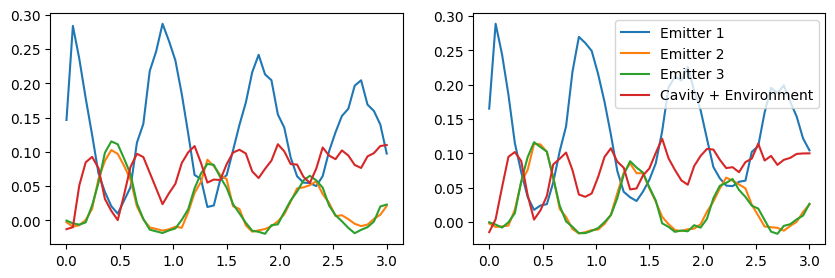

In [14]:
rc_data = aqt_results.xs("RC", level="Protocol")
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for num_rand, ax in zip([40, 80], axes):
    for col, bitstr in aqt_bitstrs.items():
        data = rc_data.xs(num_rand, level="Randomizations")
        diff = qutip_results[col] - np.array(data[bitstr])
        print(col, "RMS", np.sqrt(np.sum(diff**2)))
        rms[f"RC {num_rand}"][col] = np.sqrt(np.sum(diff**2))
        mae[f"RC {num_rand}"][col] = np.mean(np.abs(diff))
        mre[f"RC {num_rand}"][col] = np.mean(np.abs(diff).iloc[1:] / qutip_results[col].iloc[1:])
        ax.plot(times, diff, label=col)

plt.legend()

## Fourier

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_80097/2375254708.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


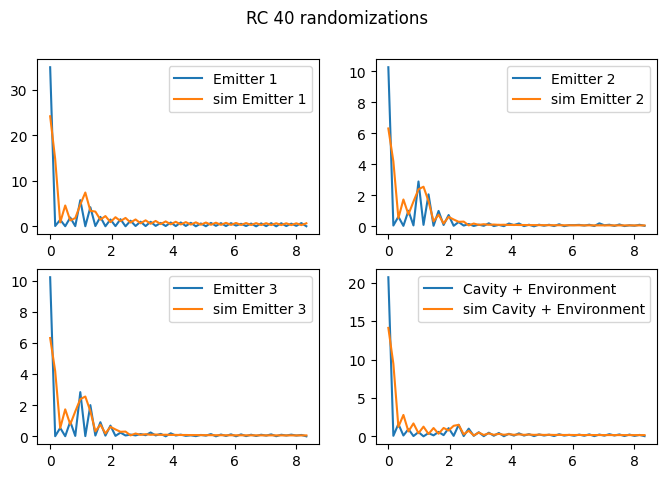

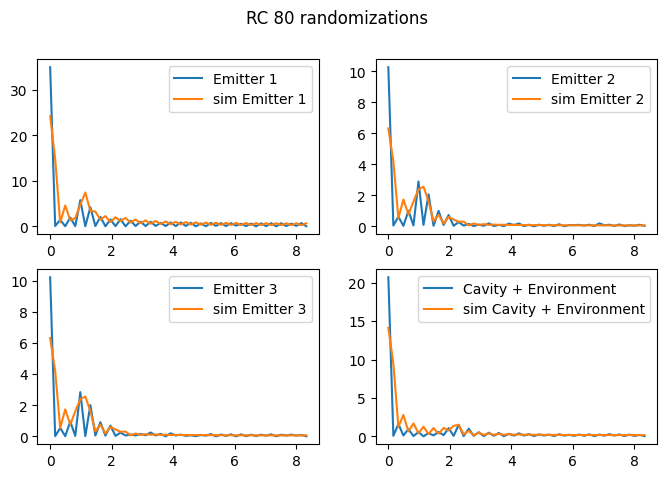

In [15]:
n = len(rc_data)

for num_rand, ax in zip([40, 80], axes):
    fig, axes = plt.subplots(2, 2, figsize=(8, 5))
    fig.suptitle(f"RC {num_rand} randomizations")

    for (col, bitstr), ax in zip(aqt_bitstrs.items(), axes.flatten()):
        fft = np.fft.rfft(rc_data[bitstr], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label=col)

        fft = np.fft.rfft(qutip_results[col], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label="sim " + col)

        ax.legend()
    
    fig.show()

# normed RC

## RMS and MAE

Emitter 1 RMS 0.31795350254107285
Emitter 2 and 3 RMS 0.16613912966221794
Cavity + Environment RMS 0.14103570668243184
Emitter 1 RMS 0.3030010670352208
Emitter 2 and 3 RMS 0.16661055619503243
Cavity + Environment RMS 0.14305397479065507


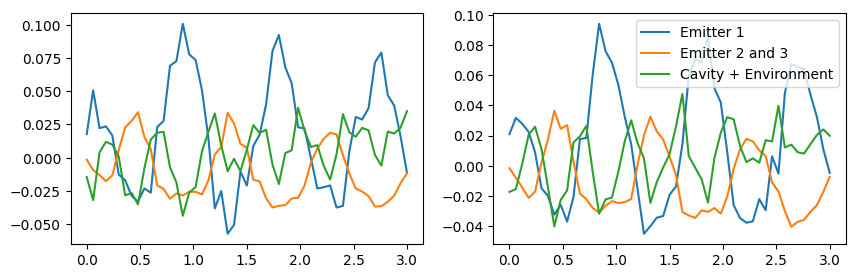

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for num_rand, ax in zip([40, 80], axes):
    data = rc_data.xs(num_rand, level="Randomizations")

    rc_data_norm = norm_and_average(data)

    for col, bitstr in normed_bitstrs.items():
        diff = qutip_results[col] - np.array(rc_data_norm[bitstr])
        print(col, "RMS", np.sqrt(np.sum(diff**2)))
        rms[f"RC {num_rand} normed"][col] = np.sqrt(np.sum(diff**2))
        mae[f"RC {num_rand} normed"][col] = np.mean(np.abs(diff))
        mre[f"RC {num_rand} normed"][col] = np.mean(np.abs(diff).iloc[1:] / qutip_results[col].iloc[1:])
        ax.plot(times, diff, label=col)

plt.legend()

## Fourier

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_80097/3319259109.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


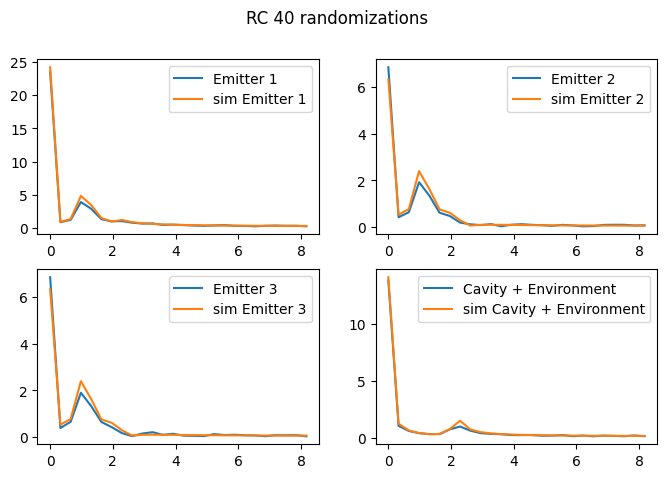

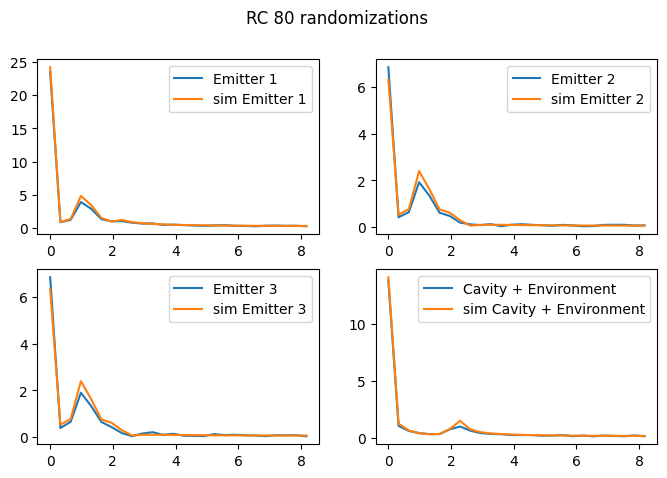

In [17]:
n = len(rc_data_norm)

for num_rand, ax in zip([40, 80], axes):
    fig, axes = plt.subplots(2, 2, figsize=(8, 5))
    fig.suptitle(f"RC {num_rand} randomizations")

    for (col, bitstr), ax in zip(aqt_bitstrs.items(), axes.flatten()):
        fft = np.fft.rfft(rc_data_norm[bitstr], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label=col)

        fft = np.fft.rfft(qutip_results[col], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label="sim " + col)

        ax.legend()
    
    fig.show()

# RC + NOX

## RMS and MAE

Emitter 1 RMS 0.6904460422330536
Emitter 2 RMS 0.4485357407743916
Emitter 3 RMS 0.3118983517551639
Cavity + Environment RMS 0.4520841589404127
Emitter 1 RMS 0.4589501507391201
Emitter 2 RMS 0.25850643441043275
Emitter 3 RMS 0.20475941961044236
Cavity + Environment RMS 0.30444556856917804
Emitter 1 RMS 0.4351243072908241
Emitter 2 RMS 0.25418552184091026
Emitter 3 RMS 0.18827687165319384
Cavity + Environment RMS 0.2979099104463711
Emitter 1 RMS 0.44385359050269474
Emitter 2 RMS 0.20469949116747976
Emitter 3 RMS 0.17764017174518906
Cavity + Environment RMS 0.2632200557650882
Emitter 1 RMS 0.5297324648205586
Emitter 2 RMS 0.21266654368857205
Emitter 3 RMS 0.18908245721916053
Cavity + Environment RMS 0.2701726075728844


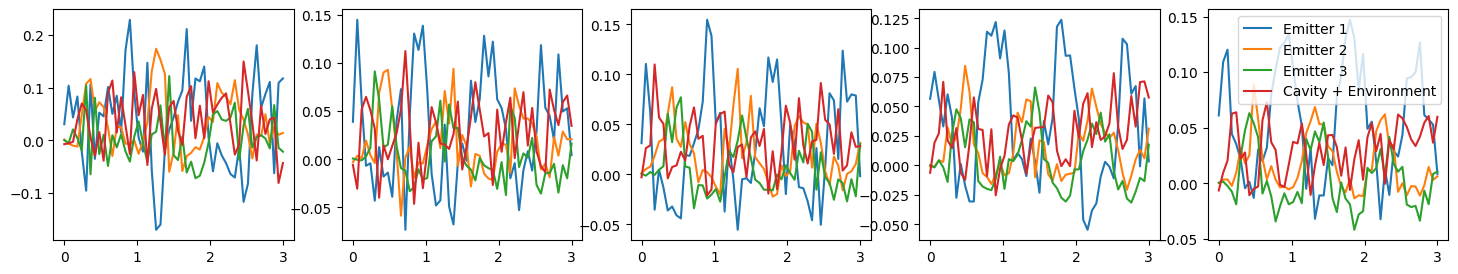

In [18]:
nox_data = aqt_results.xs("NOX", level="Protocol")

fig, axes = plt.subplots(1, 5, figsize=(18, 3))

for num_ident, ax in zip([1, 2, 3, 4, 6], axes):
    for col, bitstr in aqt_bitstrs.items():
        data = nox_data.xs(num_ident, level="Identities")
        diff = qutip_results[col] - np.array(data[bitstr])
        print(col, "RMS", np.sqrt(np.sum(diff**2)))
        rms[f"NOX {num_ident}"][col] = np.sqrt(np.sum(diff**2))
        mae[f"NOX {num_ident}"][col] = np.mean(np.abs(diff))
        mre[f"NOX {num_ident}"][col] = np.mean(np.abs(diff).iloc[1:] / qutip_results[col].iloc[1:])
        ax.plot(times, diff, label=col)

plt.legend()

## Fourier

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_80097/363087379.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


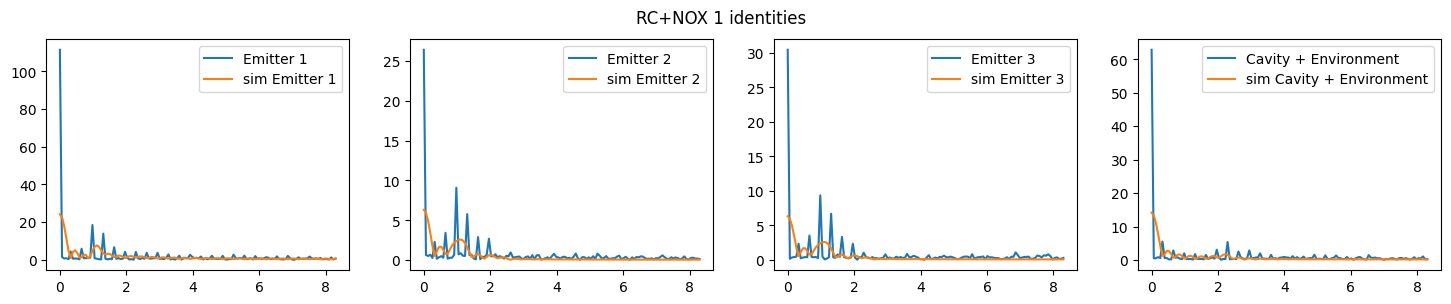

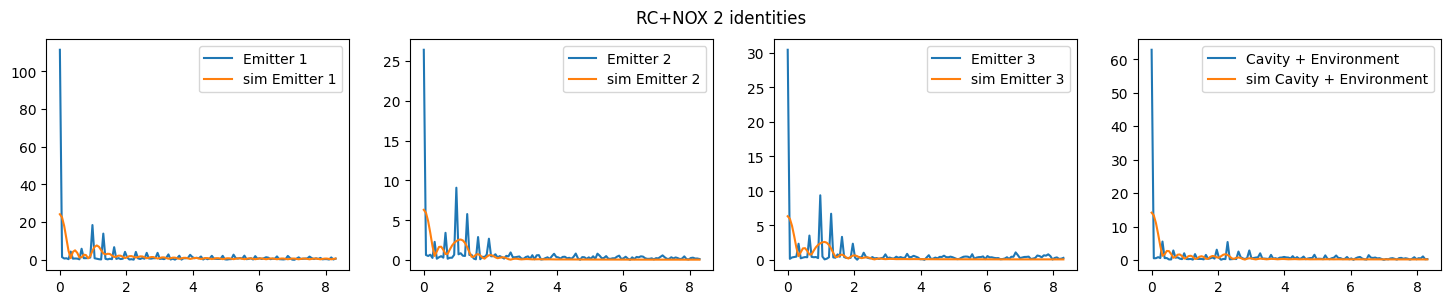

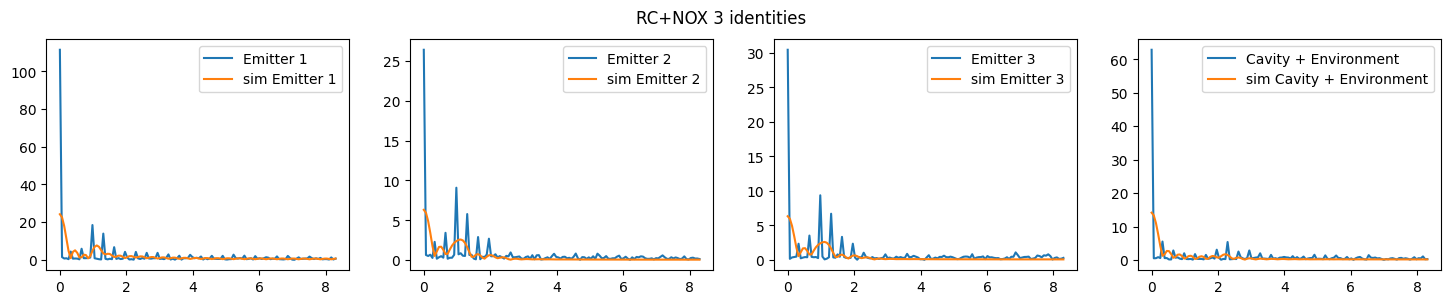

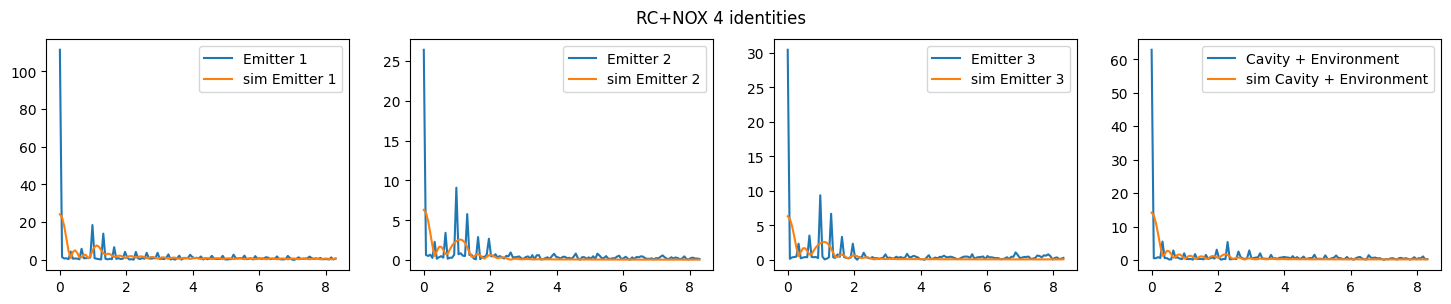

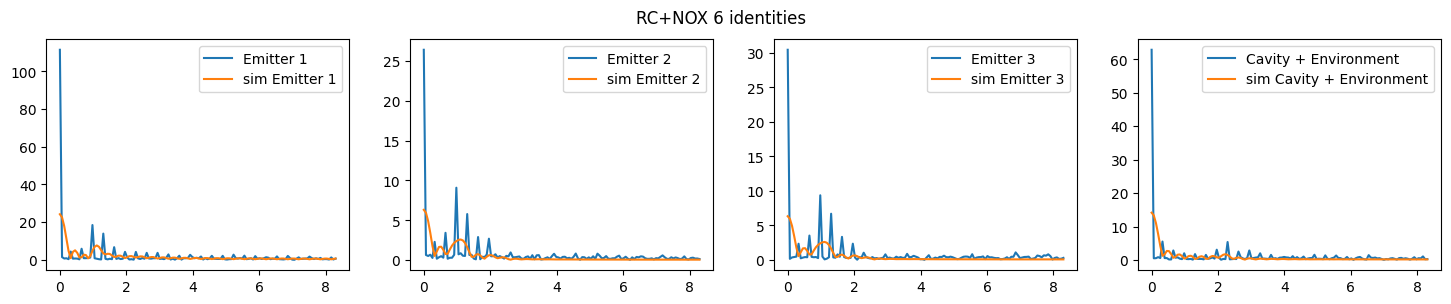

In [19]:
n = len(nox_data)

for num_ident in [1, 2, 3, 4, 6]:
    fig, axes = plt.subplots(1, 4, figsize=(18, 3))

    fig.suptitle(f"RC+NOX {num_ident} identities")

    for (col, bitstr), ax in zip(aqt_bitstrs.items(), axes.flatten()):
        fft = np.fft.rfft(nox_data[bitstr], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label=col)

        fft = np.fft.rfft(qutip_results[col], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label="sim " + col)

        ax.legend()
    
    fig.show()

# normed RC + NOX

## RMS and MAE

Emitter 1 RMS 0.6683860017073481
Emitter 2 and 3 RMS 0.2769675299074501
Cavity + Environment RMS 0.36977513509434146
Emitter 1 RMS 0.3557360657929602
Emitter 2 and 3 RMS 0.14759260565640958
Cavity + Environment RMS 0.23152709474012628
Emitter 1 RMS 0.34045128819264986
Emitter 2 and 3 RMS 0.1334295302273779
Cavity + Environment RMS 0.20765005450517113
Emitter 1 RMS 0.30236089498620405
Emitter 2 and 3 RMS 0.12336465941805928
Cavity + Environment RMS 0.17229548247316265
Emitter 1 RMS 0.2627197978640465
Emitter 2 and 3 RMS 0.13101421619926817
Cavity + Environment RMS 0.15178607502507013


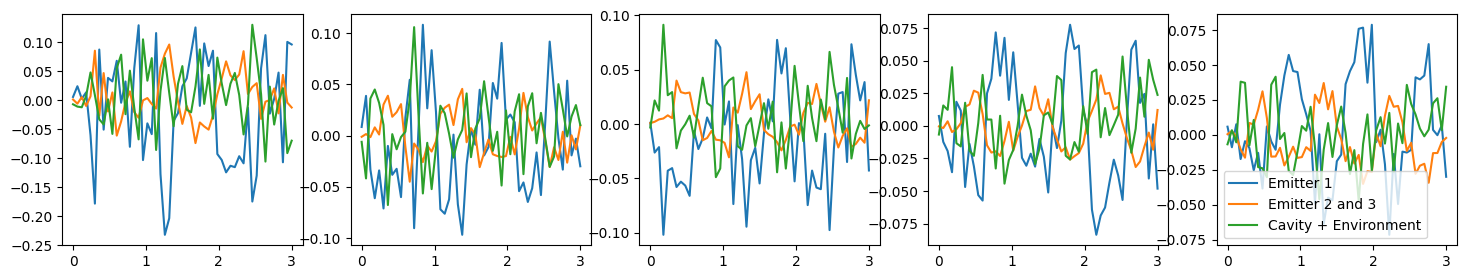

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3))

for num_ident, ax in zip([1, 2, 3, 4, 6], axes):
    data = nox_data.xs(num_ident, level="Identities")

    nox_data_norm = norm_and_average(data)

    for col, bitstr in normed_bitstrs.items():
        diff = qutip_results[col] - np.array(nox_data_norm[bitstr])
        print(col, "RMS", np.sqrt(np.sum(diff**2)))
        rms[f"NOX {num_ident} normed"][col] = np.sqrt(np.sum(diff**2))
        mae[f"NOX {num_ident} normed"][col] = np.mean(np.abs(diff))
        mre[f"NOX {num_ident} normed"][col] = np.mean(np.abs(diff).iloc[1:] / qutip_results[col].iloc[1:])
        ax.plot(times, diff, label=col)

plt.legend()

## Fourier

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_80097/2811845890.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


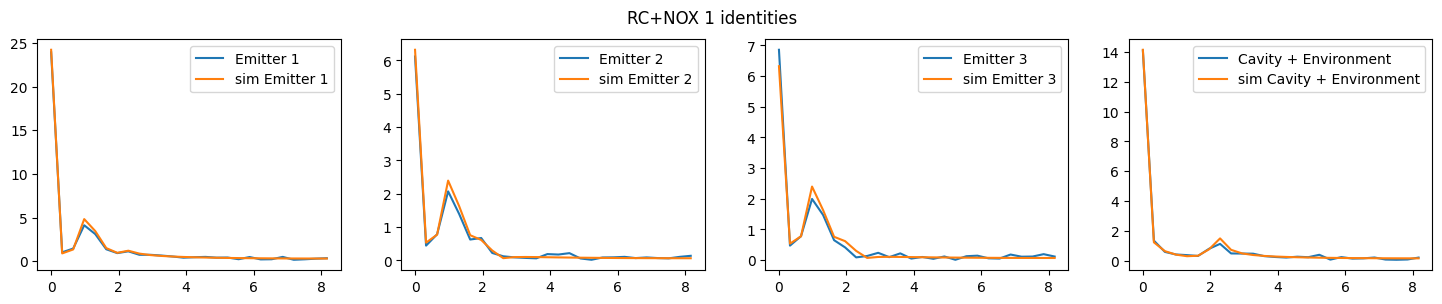

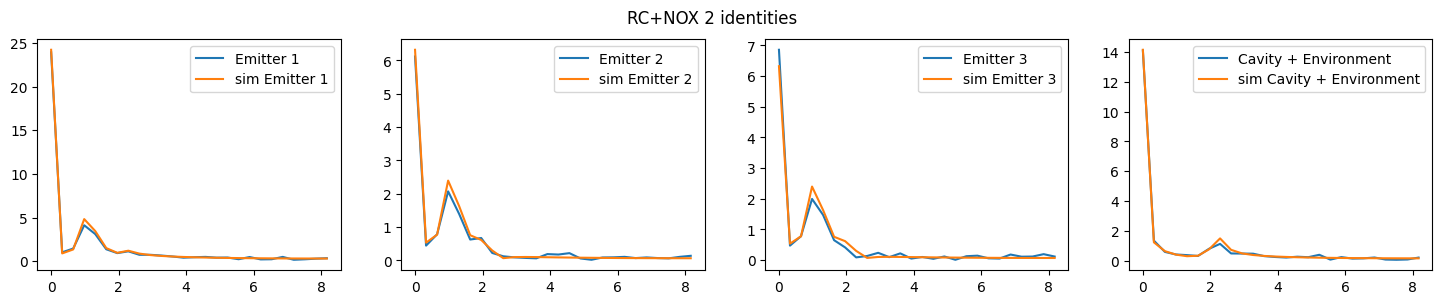

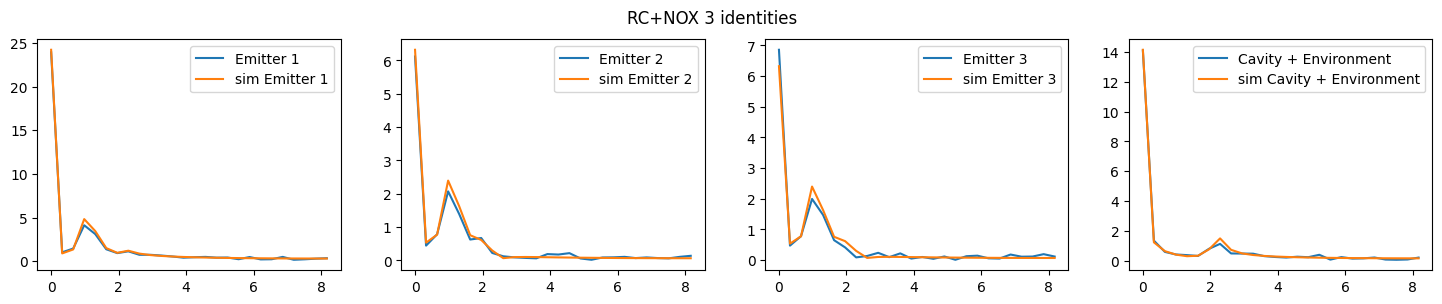

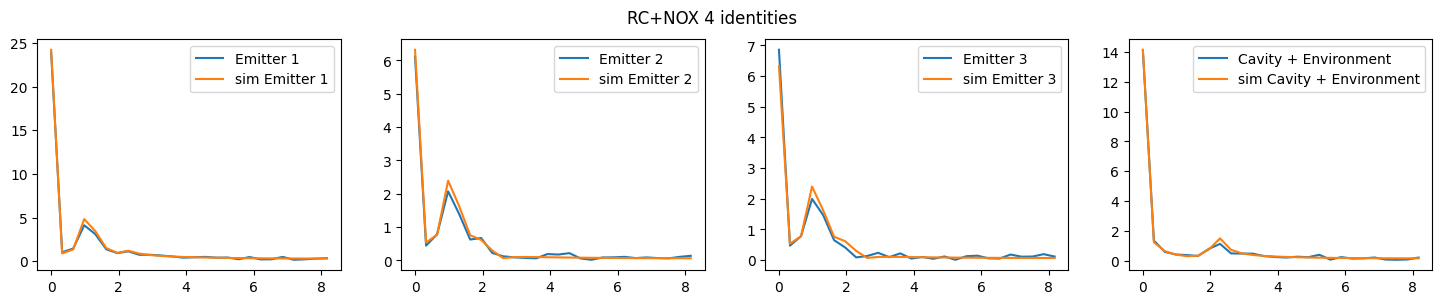

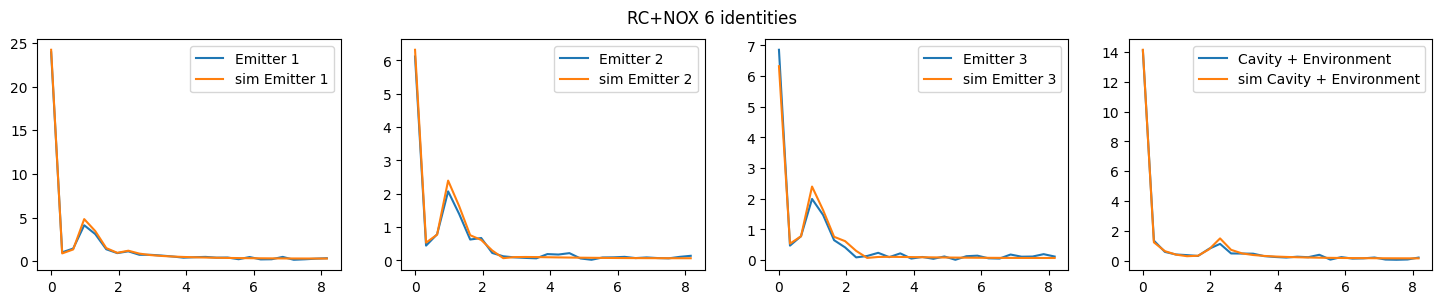

In [21]:
n = len(nox_data_norm)

for num_ident in [1, 2, 3, 4, 6]:
    fig, axes = plt.subplots(1, 4, figsize=(18, 3))

    fig.suptitle(f"RC+NOX {num_ident} identities")

    for (col, bitstr), ax in zip(aqt_bitstrs.items(), axes.flatten()):
        fft = np.fft.rfft(nox_data_norm[bitstr], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label=col)

        fft = np.fft.rfft(qutip_results[col], n)
        freqs = np.fft.rfftfreq(n, times[1] - times[0])
        ax.plot(freqs, np.abs(fft), label="sim " + col)

        ax.legend()
    
    fig.show()

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_80097/1462939630.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


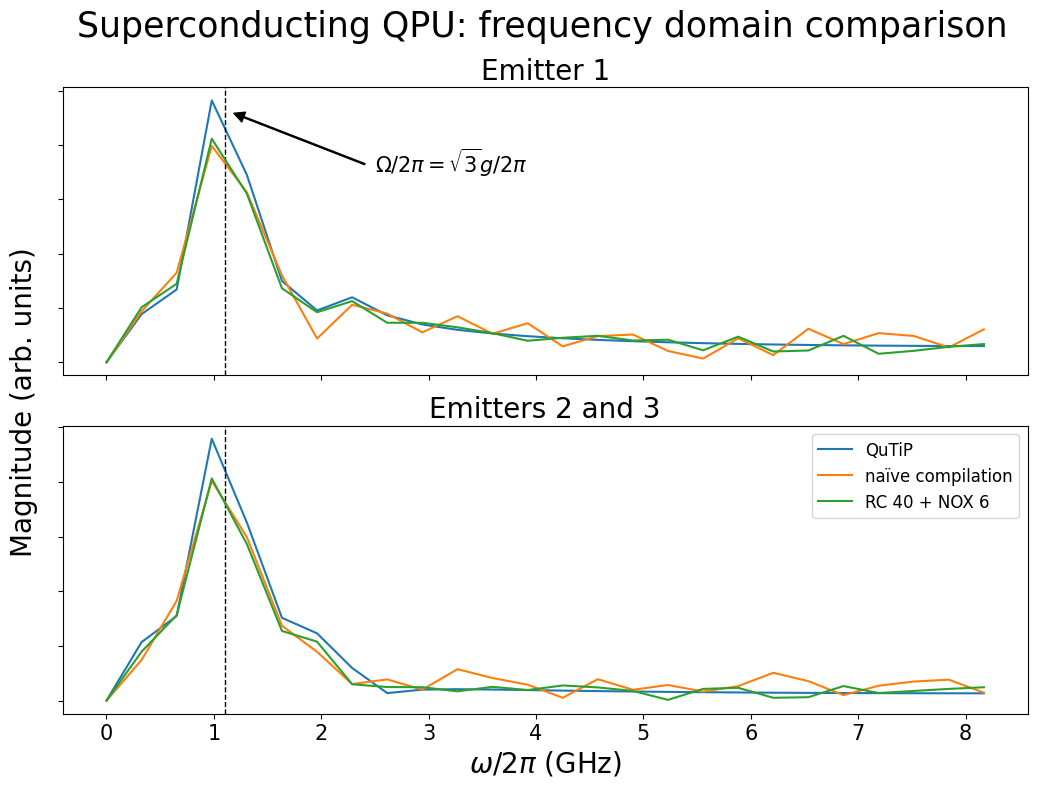

In [41]:
# Paper fourier for AQT
rabi_freq = np.sqrt(3) * g / (2*np.pi)

n = len(raw_data_norm)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

freqs = np.fft.rfftfreq(n, times[1] - times[0])
##

em1_fft_qt = np.abs(np.fft.rfft(qutip_results["Emitter 1"] - qutip_results["Emitter 1"].mean(), n))
axes[0].plot(freqs, em1_fft_qt, label="QuTiP")

em1_fft = np.abs(np.fft.rfft(raw_data_norm[normed_bitstrs["Emitter 1"]] - raw_data_norm[normed_bitstrs["Emitter 1"]].mean(), n))
axes[0].plot(freqs, em1_fft, label="naïve compilation")

axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_title("Emitter 1", fontsize=20)
axes[0].axvline(rabi_freq, lw=1, color='black', linestyle='--')

##

em23_fft = np.abs(np.fft.rfft(qutip_results["Emitter 2"] - qutip_results["Emitter 2"].mean(), n))
axes[1].plot(freqs, em23_fft, label="QuTiP")

em23_fft = np.abs(np.fft.rfft(raw_data_norm[normed_bitstrs["Emitter 2 and 3"]] - raw_data_norm[normed_bitstrs["Emitter 2 and 3"]].mean(), n))
axes[1].plot(freqs, em23_fft, label="naïve compilation")

axes[1].tick_params(axis='x', labelsize=15)
axes[1].set_yticklabels([])
axes[1].set_title("Emitters 2 and 3", fontsize=20)
axes[1].axvline(rabi_freq, lw=1, color='black', linestyle='--')


### nox on lower row
data = aqt_results.xs("NOX", level="Protocol").xs(6, level="Identities")
nox_data_norm = norm_and_average(data)

em1_fft_nox = np.abs(np.fft.rfft(nox_data_norm[normed_bitstrs["Emitter 1"]] - nox_data_norm[normed_bitstrs["Emitter 1"]].mean(), n))
axes[0].plot(freqs, em1_fft_nox, label="RC 40 + NOX 6")

em23_fft_nox = np.abs(np.fft.rfft(nox_data_norm[normed_bitstrs["Emitter 2 and 3"]] - nox_data_norm[normed_bitstrs["Emitter 2 and 3"]].mean(), n))
axes[1].plot(freqs, em23_fft_nox, label="RC 40 + NOX 6")



# axes[0].set_xlabel(r"$\omega / 2\pi$ (GHz)", fontsize=20)
axes[1].set_xlabel(r"$\omega / 2\pi$ (GHz)", fontsize=20)


##
fig.text(-0.04, 0.45, "Magnitude (arb. units)", transform=axes[0].transAxes,
        ha='center', va='top', fontsize=20, rotation=90)
##
axes[0].annotate(
    r'$\Omega/2\pi = \sqrt{3}g/2\pi$', # the text of the annotation
    fontsize=15,
    xy=(rabi_freq + 0.06, 4.6),       # the point (x,y) to annotate
    xytext=(2.5, 3.5),   # the position of the text (x,y)
    arrowprops=dict(
        arrowstyle="simple, tail_width=0.05, head_width=.5, head_length=.5",
        connectionstyle="arc3",  # connection style
        facecolor='black',
        relpos=(-0.05, 0.4),
    )
)
##

fig.suptitle("Superconducting QPU: frequency domain comparison", fontsize=25)
plt.legend(fontsize=12)
plt.tight_layout()
fig.show()

In [42]:
fig.savefig("../../figures/AQT_fourier.eps", bbox_inches="tight")

# Plot all RMS values

In [24]:
all_rms = pd.DataFrame.from_dict(rms, orient="index")
all_mae = pd.DataFrame.from_dict(mae, orient="index")
all_mre = pd.DataFrame.from_dict(mre, orient="index")

In [25]:
all_rms

,Emitter 1,Emitter 2,Emitter 3,Cavity + Environment,Emitter 2 and 3
raw,1.450243,0.318997,0.438803,0.609588,NaN
raw normed,0.608017,NaN,NaN,0.330787,0.266349
RC 40,1.089370,0.292293,0.316473,0.564501,NaN
RC 40 normed,0.317954,NaN,NaN,0.141036,0.166139
RC 80,1.076922,0.313027,0.316595,0.576646,NaN
RC 80 normed,0.303001,NaN,NaN,0.143054,0.166611
NOX 1,0.690446,0.448536,0.311898,0.452084,NaN
NOX 1 normed,0.668386,NaN,NaN,0.369775,0.276968
NOX 2,0.458950,0.258506,0.204759,0.304446,NaN
NOX 2 normed,0.355736,NaN,NaN,0.231527,0.147593


In [26]:
all_mae

,Emitter 1,Emitter 2,Emitter 3,Cavity + Environment,Emitter 2 and 3
raw,0.185557,0.037408,0.043405,0.078061,NaN
raw normed,0.071637,NaN,NaN,0.033122,0.032482
RC 40,0.132585,0.029126,0.031842,0.073765,NaN
RC 40 normed,0.037301,NaN,NaN,0.016662,0.020785
RC 80,0.131022,0.031142,0.030863,0.075565,NaN
RC 80 normed,0.036141,NaN,NaN,0.016908,0.020737
NOX 1,0.080350,0.046055,0.034080,0.052053,NaN
NOX 1 normed,0.077163,NaN,NaN,0.041283,0.029922
NOX 2,0.050986,0.026296,0.021105,0.035585,NaN
NOX 2 normed,0.041176,NaN,NaN,0.025312,0.016665


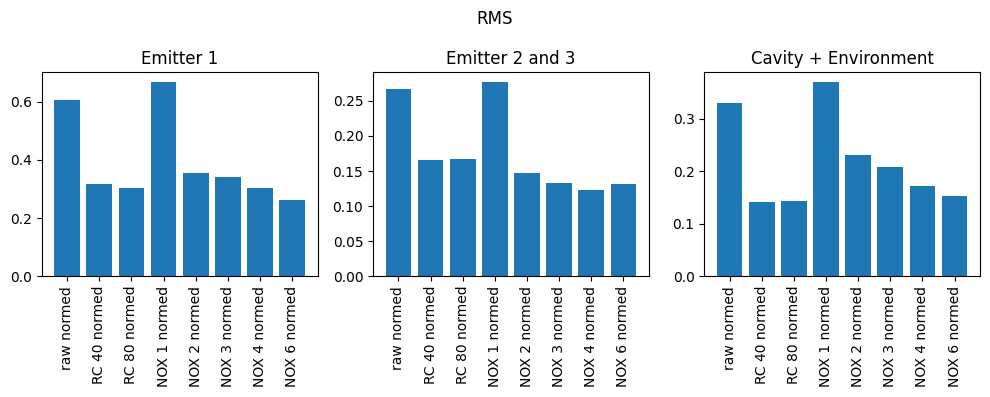

In [27]:
# normed RMS
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

norm_rows = [r for r in all_rms.index if 'norm' in r]
norm_rms = all_rms.loc[norm_rows]

for col, ax in zip(normed_bitstrs, axes.flatten()):
    ax.bar(norm_rows, norm_rms[col])
    
    ax.set_xticks(np.arange(len(norm_rms)))
    ax.set_xticklabels(norm_rms.index, rotation=90)

    ax.set_title(col)

fig.suptitle("RMS")
plt.tight_layout()

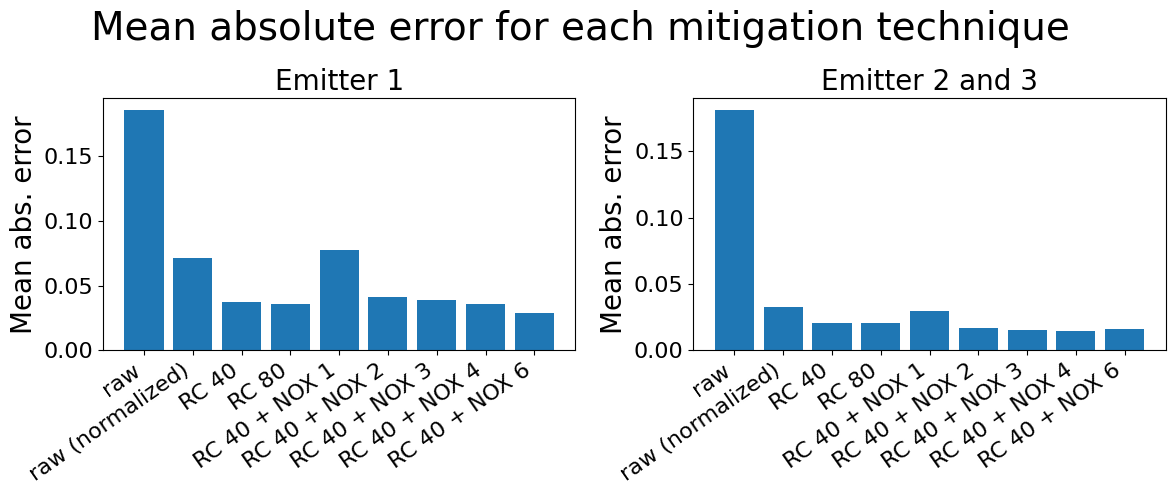

In [28]:
# normed MAE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

norm_rows = ['raw'] + [r for r in all_mae.index if 'norm' in r]
norm_mae = all_mae.loc[norm_rows]
norm_mae.loc["raw", "Emitter 2 and 3"] = raw_23_mean_mae

labels = [
    "raw",
    "raw (normalized)",
    "RC 40",
    "RC 80",
    "RC 40 + NOX 1",
    "RC 40 + NOX 2",
    "RC 40 + NOX 3",
    "RC 40 + NOX 4",
    "RC 40 + NOX 6",
]

axes[0].bar(norm_rows, norm_mae["Emitter 1"])
axes[0].set_xticks(np.arange(len(norm_mae)))
axes[0].set_xticklabels(labels, rotation=35, ha='right', fontsize=16)
axes[0].tick_params(axis='y', labelsize=16)
axes[0].set_title("Emitter 1", fontsize=20)
axes[0].set_ylabel("Mean abs. error", fontsize=20)

axes[1].bar(norm_rows, norm_mae["Emitter 2 and 3"])
axes[1].set_xticks(np.arange(len(norm_mae)))
axes[1].set_xticklabels(labels, rotation=35, ha='right', fontsize=16)
axes[1].tick_params(axis='y', labelsize=16)
axes[1].set_title("Emitter 2 and 3", fontsize=20)
axes[1].set_ylabel("Mean abs. error", fontsize=20)

fig.suptitle("Mean absolute error for each mitigation technique", fontsize=28)
plt.tight_layout()
fig.subplots_adjust(wspace=0.25)

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_80097/1245232275.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(right_labels, rotation=35, ha='right', fontsize=15)


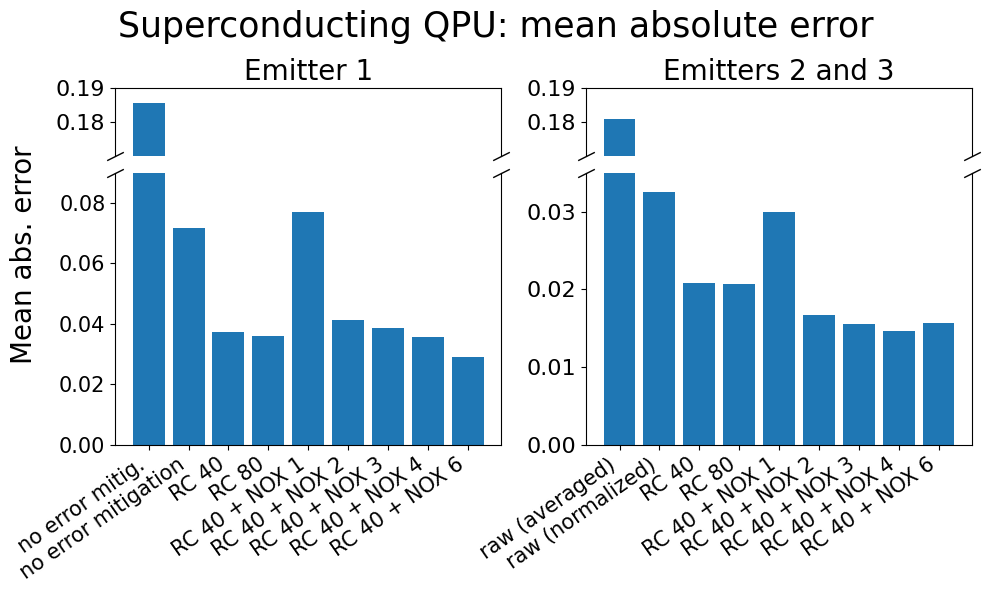

In [32]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 6))

gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1,4])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

left_labels = list(labels)
left_labels[0] = "no error mitig."
left_labels[1] = "no error mitigation"

ax2.bar(norm_rows, norm_mae["Emitter 1"])
ax2.set_xticks(np.arange(len(norm_mae)))
ax2.set_xticklabels(left_labels, rotation=35, ha='right', fontsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.set_ylabel("Mean abs. error", fontsize=20)
ax2.yaxis.set_label_coords(-0.2, 0.7)  # Adjust these values as needed

ax2.set_ylim(0, 0.09)
ax2.set_yticks([0, 0.02, 0.04, 0.06, 0.08])

ax1.bar(norm_rows, norm_mae["Emitter 1"])
ax1.tick_params(axis='y', labelsize=16)
ax1.set_ylim(0.17, 0.19)
ax1.set_yticks([0.18, 0.19])

ax1.set_title("Emitter 1", fontsize=20)
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()
ax1.set_xticks([])


### right side plots
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])

right_labels = ["raw (averaged)"] + labels[1:]
ax4.bar(norm_rows, norm_mae["Emitter 2 and 3"])
ax4.set_xticklabels(right_labels, rotation=35, ha='right', fontsize=15)
ax4.set_ylim(0, 0.035)

ax3.bar(norm_rows, norm_mae["Emitter 2 and 3"])
ax3.set_ylim(0.17, 0.19)
ax3.set_yticks([0.18, 0.19])
ax4.set_yticks([0, 0.01, 0.02, 0.03])

ax3.set_title("Emitters 2 and 3", fontsize=20)
ax3.spines.top.set_visible(True)
ax3.spines.bottom.set_visible(False)
ax3.set_xticks([])
ax3.tick_params(axis='y', labelsize=16)
ax4.tick_params(axis='y', labelsize=16)
ax4.spines.top.set_visible(False)

d = 0.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 1], [0, 0], transform=ax3.transAxes, **kwargs)
ax4.plot([0, 1], [1, 1], transform=ax4.transAxes, **kwargs)

plt.tight_layout()
fig.suptitle("Superconducting QPU: mean absolute error", fontsize=25)
fig.subplots_adjust(top=0.85, hspace=0.1, wspace=0.22)
plt.show()

In [33]:
fig.savefig("../../figures/AQT_mean_abs_error.eps", bbox_inches="tight")

In [ ]:
norm_mae

In [ ]:
# Overall RMS
plt.bar(all_rms.index, all_rms.sum(axis=1))
plt.xticks(all_rms.index, rotation=90)
plt.title("RMS")
plt.show()

In [ ]:
# Overall RMS not normed
not_norm_rows = [r for r in all_rms.index if "norm" not in r]
not_norm_rms = all_rms.loc[not_norm_rows]
not_norm_rms

plt.bar(not_norm_rms.index, not_norm_rms.sum(axis=1))
plt.xticks(not_norm_rms.index, rotation=90)
plt.title("RMS")
plt.show()

In [ ]:
# Overall RMS normed
plt.bar(norm_rms.index, norm_rms.sum(axis=1))
plt.xticks(norm_rms.index, rotation=35, ha="right")
plt.title("RMS")
plt.show()

In [ ]:
plt.bar(all_mae.index, all_mae.sum(axis=1))
plt.xticks(all_mae.index, rotation=90)
plt.title("MAE")
plt.show()

In [ ]:
plt.bar(norm_mae.index, norm_mae.sum(axis=1))
plt.xticks(norm_mae.index, rotation=90)
plt.title("MAE")
plt.show()

In [ ]:
all_mae.sum(axis=1)

In [ ]:
all_rms.sum(axis=1)

In [ ]:
# Overall RMS
plt.bar(all_mre.index, all_mre.sum(axis=1))
plt.xticks(all_mre.index, rotation=90)
plt.title("RMS")
plt.show()